# Quicksort Analysis

This notebook documents the basic testing methodology and results of the quicksort experiment. This experiment was executed using one of the Grid 5000 machines in order to have a more powerful setup and extended performance.

## Machine setup

This section contains a concise, reproducible summary of the machine used for the experiments.

**Hardware**

- **CPU:** Intel(R) Xeon(R) Gold 6130 @ 2.10 GHz
- **Topology:** 4 sockets × 16 cores/socket × 2 threads/core — total **128 logical CPUs**
- **NUMA nodes:** 4
- **CPU frequency (observed):** min 1000 MHz — max 3700 MHz (sample 1428 MHz)
- **Memory:** 384 GiB DDR4 @ 2666 MT/s
- **Storage:** 2 × 1.9 TB SSD

**Software & Toolchain**

- **OS:** Debian GNU/Linux 11 (bullseye)
- **Compiler:** gcc 10.2.1 (build flags used: `-w -O3`)

## Testing methodology

Summary of the benchmark driver script used to collect CSV measurements:

### Summary

- **Output layout:** measurements are saved under `data/<hostname>_<date>/measurements_<HH:MM>.csv` with header: `size,type,time,freq_before_ghz,freq_after_ghz,threads,peak_memory_mb`.
- **Input sizes:** a concatenation of sequences varying from very small to very large (1..10, 10..100 step 5, 100..1000 step 50, 1000..10000 step 500, 10000..100000 step 5000, 100000..1_000_000 step 50000).
- **Repetitions:** each size, type and thread level is repeated **5** times.
- **Randomization:** all runs are shuffled (`sort -R`) so measurements execute in a fully random order to reduce temporal bias.
- **Warmup:** before measuring, the benchmark runs **5 warmup iterations** at size 10000 to stabilize CPU/memory/cache effects.
- **Test types:** for each size the script runs three types: `seq` (sequential), `par` (parallel) and `built` (built-in). For `par` it runs with thread levels from **2** to **10**; non-par runs use `threads=1`.
- **Collected metrics per run:** execution time (parsed from program output), CPU frequency before/after, and peak memory (MB). The script applies a simple outlier filter: it skips entries where `time` is empty or zero.
- **Notes on reproducibility:** the script records per-run frequency and peak memory which helps identify interference and CPU scaling effects. The CSV header and example fields are used by the notebook consolidation step.

### How the thread level works

The program controls parallelism via a "thread level" parameter (macro `THREAD_LEVEL` by default). Key behavior:

- The thread level is a *recursion depth* for spawning threads. When the helper runs with `level > 0` it partitions its subarray and spawns two child threads, each with `level - 1`.
- Therefore, a thread level `L` can produce up to `2^L` concurrent worker threads at the leaf stage. Counting internal nodes, the total number of created threads is approximately `2^{L+1} - 1` (including the initial top thread created from `main`).
- Actual concurrency depends on partition sizes: if a partition is empty or becomes small, fewer threads will be created.

Mapping examples

- `level = 0` → fully sequential (no child threads spawned).
- `level = 1` → up to 2 worker threads (plus the top thread).
- `level = 3` → up to 8 worker threads.
- `level = 10` (default macro) → up to 1024 leaf workers (may hugely oversubscribe most machines).

### How the frequency is measured

The program estimates CPU frequency using the `measure_cpu_freq()` function in `src/parallelQuicksort.c`. Summary:

- The function runs a CPU-bound loop of 100,000,000 iterations using a `volatile` variable and measures wall-clock time with `gettimeofday()` before and after the loop.
- The estimated frequency is computed as `freq = operations / elapsed_time` (units: Hz), where `operations = 100000000`.

Limitations and sources of bias

- This is an indirect estimate (throughput of a busy loop), not a direct read of the core clock.
- Results vary with dynamic frequency scaling (DVFS), Turbo Boost, OS preemption, and thread migrations between cores.
- `volatile` reduces compiler optimizations, but microarchitectural effects and instruction-level optimizations can still affect the measured rate.

## Performance analysis

This sections aims to make a deep analysis on the performance of the algorithm under different aspects.

### Data importing and quick summary

Importing the necessary libraries.

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline

Importing the required data, everything should be available in a file called `measurements.csv` under the root folder of the project.

In [85]:
df = pd.read_csv('measurements.csv')

With the file loaded, we can take a quick look into the shape and statistics of the data.

In [86]:
print(f"Shape: {df.shape}")
print(df.head())

print("\n\nInfos about the dataframe:")
print(df.info())

Shape: (6300, 7)
   size type      time  freq_before_hz  freq_after_hz  level  peak_memory_mb
0    10  seq  0.000000      2094950780     2094951199      0         1.85156
1    10  par  0.000368      2094950614     2094950900      1         1.82812
2    10  par  0.001158      2094950646     2094950864      2         4.84766
3    10  par  0.001104      2094950265     2094950997      3         4.83203
4    10  par  0.001645      2094950709     2094950684      4         2.84375


Infos about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   size            6300 non-null   int64  
 1   type            6300 non-null   object 
 2   time            6300 non-null   float64
 3   freq_before_hz  6300 non-null   int64  
 4   freq_after_hz   6300 non-null   int64  
 5   level           6300 non-null   int64  
 6   peak_memory_mb  6300 

### Data cleaning

Once the file is loaded, we can begin to clean the data, removing NaN values, duplicates and outliers.

Let's begin by removing duplicates and samples where any of the values is null or NaN.

In [87]:
df = df.drop_duplicates()
df = df.dropna()
df = df[df['time'] != 0]

df['time'] = df['time'] + np.random.normal(0, 1e-9, size=len(df))

### Filtering samples with large frequency deviations

To ensure data quality, we remove samples where the frequency changes by more than 10% compared to the original frequency.

In [88]:
df_freq = df[
    (df['freq_after_hz'] >= 0.90 * df['freq_before_hz']) &
    (df['freq_after_hz'] <= 1.10 * df['freq_before_hz'])
]
print(f"Rows after frequency filter: {len(df_freq)} (removed {len(df) - len(df_freq)})")

Rows after frequency filter: 6237 (removed 0)


### Filtering out unusually high memory usage

For each combination of `size`, `type`, and `thread level`, we compute the average `peak_memory_mb`. We remove rows where the memory usage exceeds **50%** above the group average. This helps eliminate outliers and ensures that memory measurements are consistent within similar samples.

In [89]:
grouped_mem_mean = df_freq.groupby(['size', 'type', 'level'])['peak_memory_mb'].transform('mean')
df_mem = df_freq[(df_freq['size'] < 10000) |
    ((df_freq['peak_memory_mb'] >= 0.5 * grouped_mem_mean) &
    (df_freq['peak_memory_mb'] <= 1.5 * grouped_mem_mean))
]
print(f"Rows after memory filter: {len(df_mem)} (removed {len(df_freq) - len(df_mem)})")

Rows after memory filter: 6152 (removed 85)


### Filtering out time outliers

For each combination of `size`, `type`, and `thread level`, we compute the average execution time (time). We then remove rows where the execution time is more than **50%** above or below the group average.

In [90]:
grouped_time_mean = df_mem.groupby(['size', 'type', 'level'])['time'].transform('mean')
df_clean = df_mem[(df_mem['size'] < 10000) |
    (df_mem['time'] >= 0.5 * grouped_time_mean) &
    (df_mem['time'] <= 1.5 * grouped_time_mean)
]
print(f"Rows after time filter: {len(df_clean)} (removed {len(df_mem) - len(df_clean)})")

Rows after time filter: 6062 (removed 90)


## Data and Performance Analysis

This section aims to make different analysis about the data, in order to get meaningful insights about the raw execution metadata.

### Analysis of Execution Time vs. Array Size

This plot visualizes the performance comparison between different implementations (Sequential, Built-in, and Parallel) of an operation across a wide range of input sizes (Array Size), both plotted on a logarithmic scale.

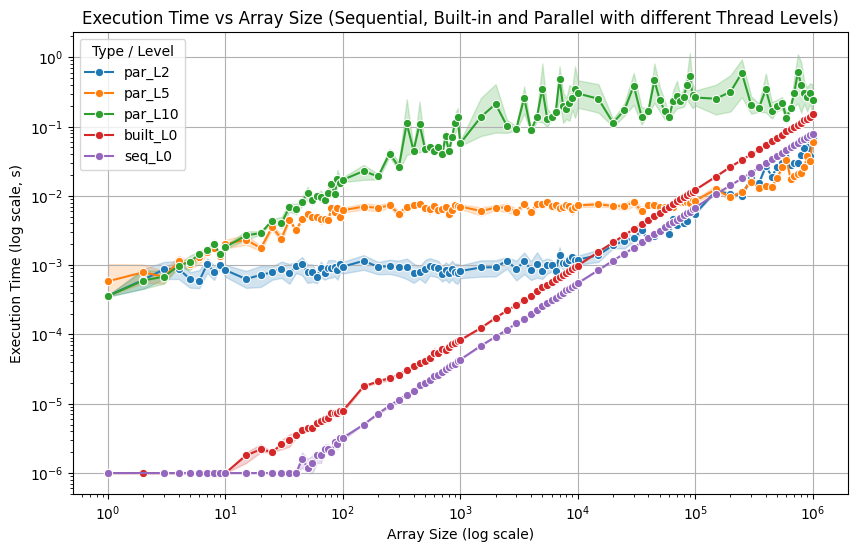

In [91]:
# Select relevant levels and types
selected_levels = [2, 5, 10]
df_filtered = df[
    ((df['type'] == 'par') & (df['level'].isin(selected_levels))) | 
    ((df['type'].isin(['seq', 'built'])) & (df['level'] == 0))
].copy()

# Create a new column combining type and level for coloring
df_filtered.loc[:, 'type_level'] = df_filtered.apply(
    lambda row: f"{row['type']}_L{row['level']}", axis=1
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_filtered, 
    x='size', 
    y='time', 
    hue='type_level',
    marker='o',
    errorbar='ci',
    palette='tab10',
)

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Array Size (log scale)')
plt.ylabel('Execution Time (log scale, s)')
plt.title('Execution Time vs Array Size (Sequential, Built-in and Parallel with different Thread Levels)')
plt.legend(title='Type / Level')
plt.show()

This plot clearly show a better performance for the `built` and `seq` methods when dealing with small array sizes. The breakpoint where the parallel approach start to get better performance depends on the thread level used for the algorithm. 

A large thread count for a small size array can mean that the program is using most of it's time creating and destroying threads instead of actually doing computations inside using them.

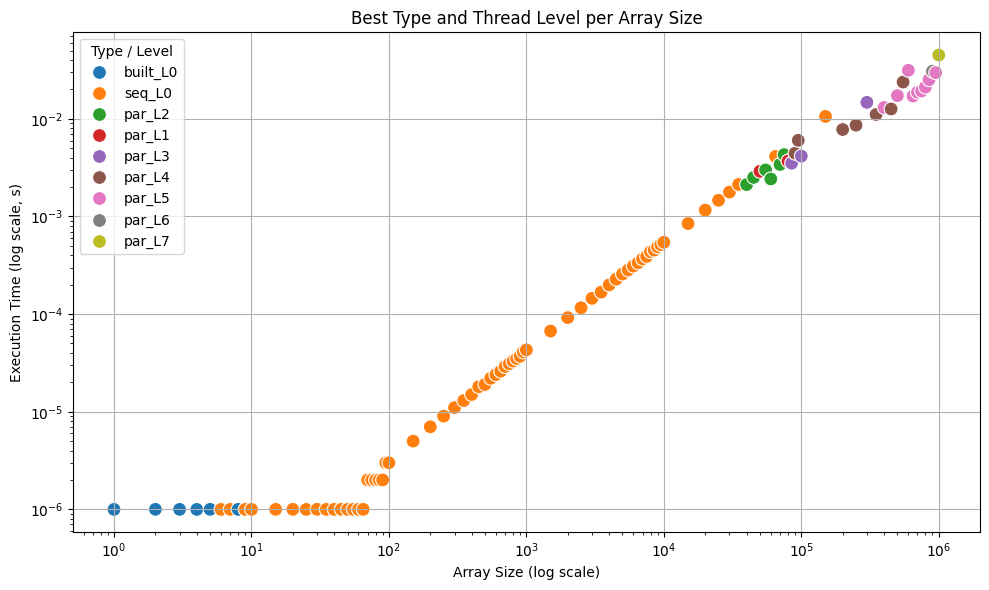

In [92]:
# For each size, select the row with the minimum execution time
df_best = df.loc[df.groupby('size')['time'].idxmin()].copy()

# Create a label combining type and level for coloring
df_best['type_level'] = df_best.apply(lambda row: f"{row['type']}_L{row['level']}", axis=1)

# --- 3. Plot ---
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_best,
    x='size',
    y='time',
    hue='type_level',
    s=100
)

# Log scales for clarity
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Array Size (log scale)')
plt.ylabel('Execution Time (log scale, s)')
plt.grid(True)
plt.title('Best Type and Thread Level per Array Size')

# Legend outside plot
plt.legend(title='Type / Level')
plt.tight_layout()
plt.show()

The plot above tries to show the best method and thread level for each array size based on average execution time to sort the array. It is possible to observe that the best method varies a lot depending on the size of the input: in general the built in and sequential method are the best for small sizes, with roughly about 10000 different floats.

After this interval, the parallel method wins the advantage with a small number of thread levels, that increases as linearly with the input. This phenomena is exactly the one commented on the plot before, it is important to manage the number of threads created in order to ensure that each thread as enough work to justify it's creation and management.

## Trying to find the optimal size for thread creation

As observed in the plots above, there exists an optimal size where creating a new thread actually benefits the performance of the algorithm, meaning that the time spent creating and managing a new thread is less than the time gained doing computations with the thread rather than doing sequentially.

The plot below tries to find this size, for each `thread level`, it calculates the breakpoint where the algorithm became better than the `seq` version. Then, it calculates the total number of threads that can be spawned by using this `thread level` and divide the array size by this number. The result should be equal to the amount of work that was given for each thread.

   level     N_opt  leaf_threads  min_work_per_thread
0      1   45000.0             2             22500.00
1      2   40000.0             4             10000.00
2      3   40000.0             8              5000.00
3      4   55000.0            16              3437.50
4      5  200000.0            32              6250.00
5      6  200000.0            64              3125.00
6      7  300000.0           128              2343.75
7      8  600000.0           256              2343.75
8      9  800000.0           512              1562.50
9     10       NaN          1024                  NaN


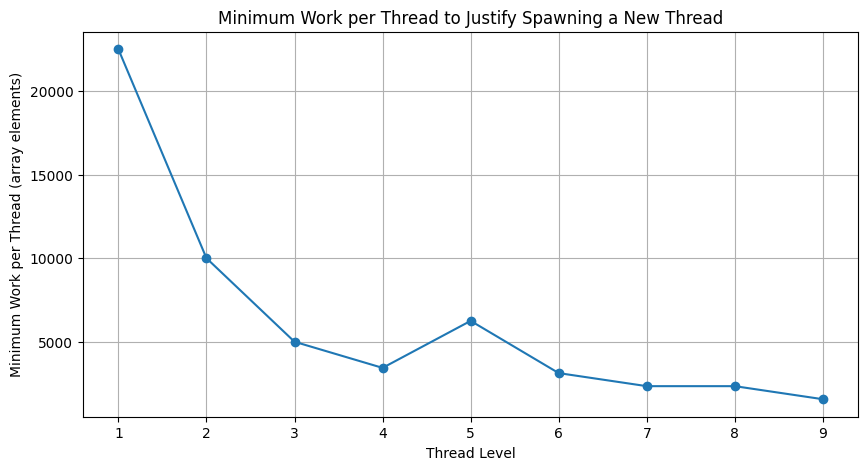

In [93]:
# Filter sequential and parallel
df_seq = df[df['type'] == 'seq']
df_par = df[df['type'] == 'par']

# Merge sequential times with parallel
df_compare = df_par.merge(
    df_seq[['size', 'time']], on='size', suffixes=('_par', '_seq')
)

# Compute speedup
df_compare['speedup'] = df_compare['time_seq'] / df_compare['time_par']

# Store optimal size and min work per thread
results = []

for level in sorted(df_compare['level'].unique()):
    df_level = df_compare[df_compare['level'] == level]
    # Smallest size where parallel is faster than sequential
    N_opt = df_level[df_level['speedup'] > 1]['size'].min()
    if N_opt is not None:
        # Compute number of leaf threads = 2^L
        leaf_threads = 2**level
        min_work_per_thread = N_opt / leaf_threads
        results.append({
            'level': level,
            'N_opt': N_opt,
            'leaf_threads': leaf_threads,
            'min_work_per_thread': min_work_per_thread
        })

df_results = pd.DataFrame(results)
print(df_results)

# --- Plot minimum work per thread ---
plt.figure(figsize=(10,5))
plt.plot(df_results['level'], df_results['min_work_per_thread'], marker='o')
plt.xlabel('Thread Level')
plt.ylabel('Minimum Work per Thread (array elements)')
plt.title('Minimum Work per Thread to Justify Spawning a New Thread')
plt.grid(True)
plt.show()

## Linear regression on collected data

The plot below tries to fit a `N * log(N)` time spent curve based on the sequential input size, which is the actual average complexity of the quicksort algorithm. It is clear that the curve fits perfectly the sample points, this being expected since we know a priori what is the actual complexity.

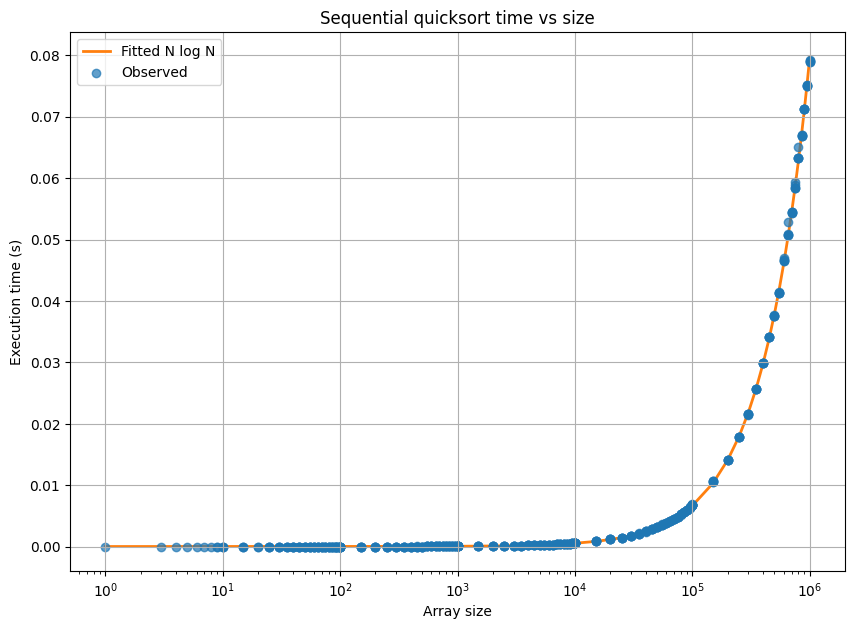

Time ≈ 5.774e-09 * N*log(N) + 1.709e-05


In [94]:
# Select only sequential rows
df_seq = df[df['type'] == 'seq']

# Features: N * log(N)  (natural log is fine)
df_seq = df_seq.copy()
df_seq['N_log_N'] = df_seq['size'] * np.log(df_seq['size'])

X = df_seq['N_log_N'].values.reshape(-1, 1)
y = df_seq['time'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Sort by size for clean plotting
df_plot = df_seq.sort_values('size')

# Predict on sorted data
X_sorted = df_plot['N_log_N'].values.reshape(-1, 1)
y_pred_sorted = model.predict(X_sorted)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(df_plot['size'], y_pred_sorted, label='Fitted N log N', color='tab:orange', linewidth=2, zorder=1)
plt.scatter(df_plot['size'], df_plot['time'], label='Observed', color='tab:blue', alpha=0.7)
plt.xscale('log')
plt.xlabel('Array size')
plt.ylabel('Execution time (s)')
plt.title('Sequential quicksort time vs size')
plt.legend()
plt.grid(True)
plt.show()

# Print coefficients
print(f"Time ≈ {model.coef_[0]:.3e} * N*log(N) + {model.intercept_:.3e}")